In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import g0

In [2]:
def load_report(path):
    return np.fromfile(path, sep = ' ').reshape((-1,7))

mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
pre = load_report('orbit/plane_change/Tianwen1_pre_planechange.txt')
post = load_report('orbit/plane_change/Tianwen1_post_planechange.txt')[::-1]
t = np.datetime64('1970-01-01') + (mjd2unixtimestamp(pre[:,0]) * 1e9) * np.timedelta64(1, 'ns')

In [4]:
post_interp = np.empty_like(pre)
post_interp[:,0] = pre[:,0]
for j in range(1, post_interp.shape[1]):
    post_interp[:,j] = np.interp(post_interp[:,0], post[:,0], post[:,j], left = np.nan, right = np.nan)

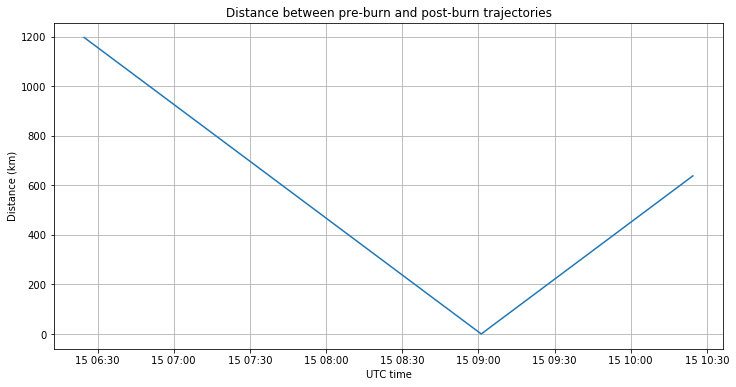

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')
dist = np.sqrt(np.sum((pre[:,1:4] - post_interp[:,1:4])**2, axis = 1))
plt.plot(t, dist)
plt.grid()
plt.title('Distance between pre-burn and post-burn trajectories')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)');

In [6]:
sel = ~np.isnan(dist)
burn_idx = np.argmin(dist[sel])
t[sel][burn_idx]

numpy.datetime64('2021-02-15T09:01:04.728000256')

In [7]:
dist[sel][burn_idx]

0.3554330180737206

In [8]:
delta_v_ms = (post_interp[sel][burn_idx, 4:] - pre[sel][burn_idx, 4:]) * 1e3
delta_v_ms

array([86.47078613, 28.956873  , 89.18999718])

In [9]:
delta_v_norm = np.sqrt(np.sum(delta_v_ms**2))
delta_v_norm

127.55607764403685

In [10]:
# Burn of 3 kN
ve = 321.6 * u.s * g0
F = 3e3 * u.N
m0 = 3600 * u.kg # estimate with 2500 kg dry mass and 1100 kg fuel
T = (ve * m0 / F * (1 - np.exp(-delta_v_norm * u.m/u.s / ve))).to(u.s)
T

<Quantity 150.01320524 s>

In [11]:
mdot = -(F/ve).to(u.kg/u.s)
deltam = mdot * T
deltam

<Quantity -142.69673278 kg>

In [12]:
# Frame with unit vector along r, unit vector along v_u (projection of v onto plane normal to r), and normal
r = pre[sel][burn_idx, 1:4]
v = pre[sel][burn_idx, 4:]
rr = r / np.sqrt(np.sum(r**2))
vr = np.dot(v,rr) * rr
vu = v - vr
vu_abs = np.sqrt(np.sum(vu**2))
vu_norm = vu / vu_abs
n = np.cross(rr, vu_norm)
U = np.matrix([rr, vu_norm, n]).T

In [13]:
# Delta-V in [r/|r|, v_u/|v_u|, N] frame
U.T @ delta_v_ms

matrix([[-20.50149576, -83.51459295,  94.2101607 ]])

In [14]:
# Initial radial velocity, in m/s
np.dot(v,rr) * 1e3

23.3032065354212

In [15]:
# Initial v_u, in m/s
vu_abs * 1e3

95.90020577177295

In [16]:
U.T @ v * 1e3

matrix([[ 2.33032065e+01,  9.59002058e+01, -4.33680869e-16]])

In [17]:
h0 = np.cross(r, v)
h0_abs = np.sqrt(np.sum(h0**2))
h0_abs

17734.584793812748

In [18]:
r1 = post_interp[sel][burn_idx, 1:4]
v1 = post_interp[sel][burn_idx, 4:]
h1 = np.cross(r1, v1)
h1_abs = np.sqrt(np.sum(h1**2))
h1_abs

17571.93011725655

In [19]:
h1_abs/h0_abs

0.9908283910535676

In [20]:
# Angle between h0 and h1
np.rad2deg(np.arccos(np.dot(h0/h0_abs, h1/h1_abs)))

82.51039652868393